In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import numpy as np
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv("sales_data_up_to_2025_04_23.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df['day'] = df['created_at'].dt.date

# Filter out sales from the last month
last_sales_date = df['day'].max()
last_month = last_sales_date.replace(day=1)
df = df[df['day'] < last_month]

# Keep only relevant columns
df = df[["day", "sku", "qty_ordered"]]

df_grouped = df.groupby(["day", "sku"]).agg({"qty_ordered": "sum"}).reset_index()
print(f"The cut-off date with the last sales is: {last_sales_date}. The new last date is now: {df['day'].max()}")
df_grouped

The cut-off date with the last sales is: 2025-04-23. The new last date is now: 2025-03-31


,day,sku,qty_ordered
0,2023-01-01,0A21331,4.0
1,2023-01-01,0A41617,1.0
2,2023-01-01,0A42658,1.0
3,2023-01-01,1029536,3.0
4,2023-01-01,104563,1.0
...,...,...,...
954787,2025-03-31,gift-595,2.0
954788,2025-03-31,gift-597,1.0
954789,2025-03-31,gift-598,2.0
954790,2025-03-31,influencer-card,1.0


In [3]:
# Load the CSV file with always active SKUs
active_skus = pd.read_csv("always_active_skus.csv")

# Filter the SKUs in the DataFrame
removed_skus = df_grouped[~df_grouped['sku'].isin(active_skus['sku'])]
remaining_skus = df_grouped[df_grouped['sku'].isin(active_skus['sku'])]

# Count the SKUs
num_removed = len(removed_skus["sku"].unique())
num_not_in_df = len(active_skus[~active_skus['sku'].isin(df['sku'])])
num_original = len(df_grouped["sku"].unique())
num_remaining = len(remaining_skus["sku"].unique())

print(f"Number of SKUs originally in DataFrame: {num_original}")
print(f"Number of SKUs removed: {num_removed}")
print(f"Number of SKUs not in the DataFrame but active: {num_not_in_df}")
print(f"Remaining SKUs: {num_remaining}")

Number of SKUs originally in DataFrame: 36207
Number of SKUs removed: 20481
Number of SKUs not in the DataFrame but active: 4631
Remaining SKUs: 15726


In [4]:
# Remove SKUs with less than certain number of days between first and last sale

min_sales_days = 31

# Create dataframe with first and last sale date for each SKU
sku_stats = remaining_skus.groupby('sku')['day'].agg(['min', 'max']).reset_index()
sku_stats.columns = ['sku', 'first_sale', 'last_sale']

# Ensure first_sale and last_sale are datetime
sku_stats['first_sale'] = pd.to_datetime(sku_stats['first_sale'])
sku_stats['last_sale'] = pd.to_datetime(sku_stats['last_sale'])

filtered_skus = sku_stats[(sku_stats['last_sale'] - sku_stats['first_sale']).dt.days > min_sales_days]
filtered_skus


initial_num = len(remaining_skus["sku"].unique())

remaining_skus = remaining_skus[remaining_skus["sku"].isin(filtered_skus["sku"])]

final_num = len(remaining_skus["sku"].unique())

print(f'Initial SKU number: {initial_num}')
print(f'Final SKU number: {final_num}')

Initial SKU number: 15726
Final SKU number: 12645


All filtering done!

All SKUs -> Only currently active SKUs -> Only SKUs that have sales for at least a month

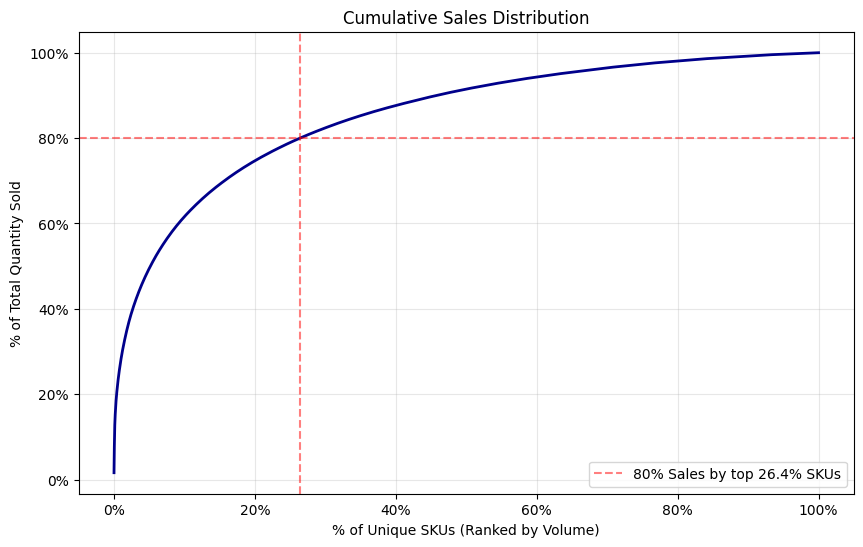

In [5]:
total_sold_per_sku = remaining_skus.groupby('sku')['qty_ordered'].sum().reset_index()

# 1. Sort data descending by quantity
df_sorted = total_sold_per_sku.sort_values(by='qty_ordered', ascending=False).copy()

# 2. Calculate Cumulative Sales % (Y-axis)
df_sorted['cum_sales_pct'] = (df_sorted['qty_ordered'].cumsum() / df_sorted['qty_ordered'].sum()) * 100

# 3. Calculate Cumulative SKU Count % (X-axis)
# Creates a range from 1/N to 100% (e.g., 0.006%, 0.012%... 100%)
df_sorted['sku_pct'] = (np.arange(len(df_sorted)) + 1) / len(df_sorted) * 100

# 4. Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_sorted['sku_pct'], df_sorted['cum_sales_pct'], color='darkblue', linewidth=2)

# Formatting
ax.set_title('Cumulative Sales Distribution')
ax.set_xlabel('% of Unique SKUs (Ranked by Volume)')
ax.set_ylabel('% of Total Quantity Sold')

# Format axes as percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add a visual reference for the "80/20 Rule"
# Find the % of SKUs that make up 80% of sales
sku_cutoff = df_sorted[df_sorted['cum_sales_pct'] >= 80]['sku_pct'].iloc[0]
plt.axvline(x=sku_cutoff, color='red', linestyle='--', alpha=0.5, label=f'80% Sales by top {sku_cutoff:.1f}% SKUs')
plt.axhline(y=80, color='red', linestyle='--', alpha=0.5)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Define cutoffs
# A = Top 80% of sales
# B = Next 15% (up to 95%)
# C = Bottom 5% of sales

def categorize_sku(cum_pct):
    if cum_pct <= 80:
        return 'A'
    elif cum_pct <= 95:
        return 'B'
    else:
        return 'C'

# Apply function
df_sorted['abc_class'] = df_sorted['cum_sales_pct'].apply(categorize_sku)

# Quick summary to verify
print(df_sorted['abc_class'].value_counts())
print("\nStats per Class:")
print(df_sorted.groupby('abc_class')['qty_ordered'].agg(['count', 'sum']))

# Save back to a variable you can use later
categorized_data = df_sorted

abc_class
C    4692
B    4613
A    3340
Name: count, dtype: int64

Stats per Class:
           count       sum
abc_class                 
A           3340  292854.0
B           4613   54924.0
C           4692   18306.0


In [7]:
# 1. Ensure strictly datetime
remaining_skus['day'] = pd.to_datetime(remaining_skus['day'])

# 2. Define the global End Date (The Cutoff)
# We still need a global start for the grid generation, but we will filter it later
global_start = remaining_skus['day'].min()
global_end = remaining_skus['day'].max()

# 3. Determine the "Birth Date" for every SKU
# This finds the very first day each specific product was sold
sku_start_dates = remaining_skus.groupby('sku')['day'].min().rename('first_sale_date')

# 4. Create the Full Grid (Cartesian Product)
# We temporarily create rows for ALL dates for ALL products
all_dates = pd.date_range(start=global_start, end=global_end, freq='D')
all_skus = remaining_skus['sku'].unique()

full_index = pd.MultiIndex.from_product(
    [all_dates, all_skus], 
    names=['day', 'sku']
)

# 5. Apply the Grid (Fill everything with 0s first)
# Note: Aggregate first to handle any duplicates
clean_sales = remaining_skus.groupby(['day', 'sku'])['qty_ordered'].sum()

df_lifecycle = (
    clean_sales
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# 6. The "Trim" Step: Remove days before the product existed
# Merge the birth dates into the main dataframe
df_lifecycle = df_lifecycle.merge(sku_start_dates, on='sku', how='left')

# Keep only rows where the Date is >= the Product's First Sale Date
df_lifecycle = df_lifecycle[df_lifecycle['day'] >= df_lifecycle['first_sale_date']]

# Cleanup columns
df_lifecycle = df_lifecycle.drop(columns=['first_sale_date']).sort_values(by=['sku', 'day'])

print(f"Global Range: {global_start.date()} to {global_end.date()}")
print(f"Total Rows (Lifecycle adjusted): {len(df_lifecycle)}")
df_lifecycle.head()

Global Range: 2023-01-21 to 2025-03-31
Total Rows (Lifecycle adjusted): 4897095


,day,sku,qty_ordered
4822985,2024-02-06,000266EV,1.0
4835630,2024-02-07,000266EV,0.0
4848275,2024-02-08,000266EV,0.0
4860920,2024-02-09,000266EV,0.0
4873565,2024-02-10,000266EV,0.0


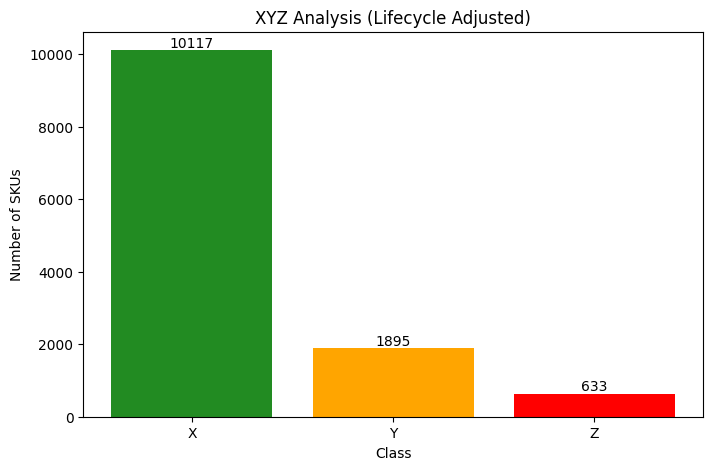

New Class Definitions (Lifecycle Adjusted):
Class X: CV Range 0.96 - 9.49
Class Y: CV Range 9.49 - 12.85
Class Z: CV Range 12.85 - 22.92


In [8]:
# --- STEP 1: RE-CALCULATE STATS FROM THE NEW LIFECYCLE DATA ---
sku_stats_new = df_lifecycle.groupby('sku')['qty_ordered'].agg(['mean', 'std'])
sku_stats_new['cv'] = sku_stats_new['std'] / sku_stats_new['mean']
sku_stats_new['cv'] = sku_stats_new['cv'].fillna(0)

# --- STEP 2: RANKING (FORCED 80/15/5) ---
sku_stats_ranked = sku_stats_new.sort_values(by='cv', ascending=True).copy()
sku_stats_ranked['rank_pct'] = sku_stats_ranked['cv'].rank(pct=True)

def get_forced_xyz(rank):
    if rank <= 0.80:
        return 'X'
    elif rank <= 0.95:
        return 'Y'
    else:
        return 'Z'

sku_stats_ranked['xyz_class'] = sku_stats_ranked['rank_pct'].apply(get_forced_xyz)

# --- STEP 3: PLOT ---
fig, ax = plt.subplots(figsize=(8, 5))
xyz_counts = sku_stats_ranked['xyz_class'].value_counts().sort_index()
colors = {'X': 'forestgreen', 'Y': 'orange', 'Z': 'red'}

bars = ax.bar(xyz_counts.index, xyz_counts.values, color=[colors[c] for c in xyz_counts.index])

ax.set_title('XYZ Analysis (Lifecycle Adjusted)')
ax.set_xlabel('Class')
ax.set_ylabel('Number of SKUs')
ax.bar_label(bars)

plt.show()

# --- STEP 4: VERIFY THE CHANGE ---
# Compare these numbers to your previous run. The "Max CV" for Class X should be lower now.
print("New Class Definitions (Lifecycle Adjusted):")
for cls in ['X', 'Y', 'Z']:
    subset = sku_stats_ranked[sku_stats_ranked['xyz_class'] == cls]
    print(f"Class {cls}: CV Range {subset['cv'].min():.2f} - {subset['cv'].max():.2f}")

MAPE for 7259986: 50.23%


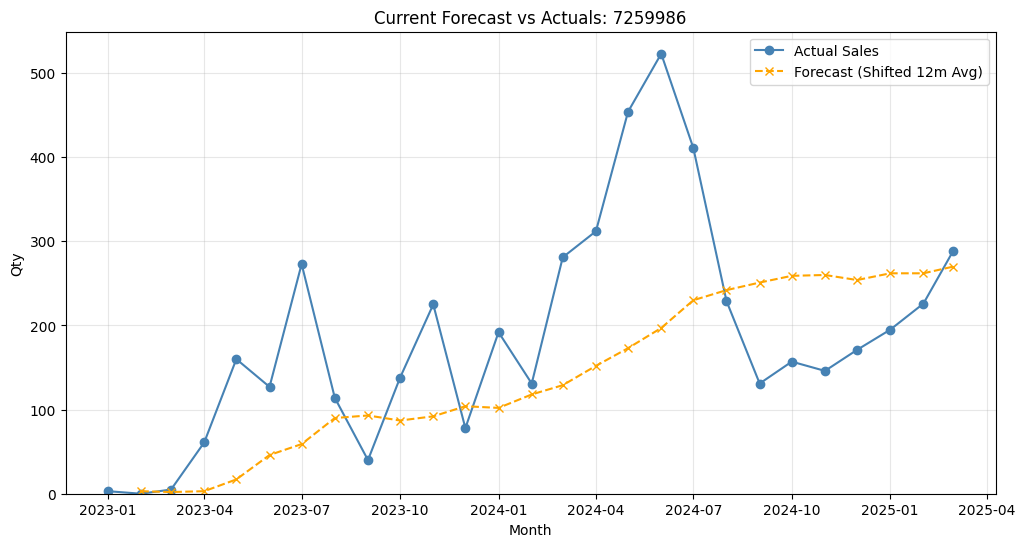


First 5 Months of Data:
       month  qty_ordered  forecast
0 2023-01-01          3.0       NaN
1 2023-02-01          0.0       3.0
2 2023-03-01          5.0       2.0
3 2023-04-01         61.0       3.0
4 2023-05-01        160.0      17.0


In [9]:
# Define the SKU
sku_to_analyze = "7259986" 

# 1. Filter the PRE-CLEANED lifecycle dataframe
sku_daily_data = df_lifecycle[df_lifecycle['sku'] == sku_to_analyze].copy()

if sku_daily_data.empty:
    print(f"No data found for SKU {sku_to_analyze} in df_lifecycle.")
else:
    # 2. Resample Daily -> Monthly
    monthly_sales = (
        sku_daily_data.set_index('day')
        .resample('MS')['qty_ordered']
        .sum()
        .reset_index()
    )
    monthly_sales.rename(columns={'day': 'month'}, inplace=True)

    # 3. Calculate Forecast (Rolling Average -> Shifted)
    # Step A: Calculate the moving average of the PREVIOUS 12 months
    # Step B: .shift(1) moves the result down one row. 
    #         So the avg of Jan becomes the forecast for Feb.
    monthly_sales['forecast'] = (
        monthly_sales['qty_ordered']
        .rolling(window=12, min_periods=1)
        .mean()
        .shift(1) 
        .round()
    )

    # 4. Compute MAPE (ignoring the first month where forecast is NaN)
    valid_data = monthly_sales.dropna(subset=['forecast'])
    
    def compute_mape(actual, forecast):
        total_absolute_error = abs(actual - forecast).sum()
        total_actual = actual.sum()
        
        if total_actual == 0: 
            return 0.0
        return (total_absolute_error / total_actual) * 100

    mape = compute_mape(valid_data['qty_ordered'], valid_data['forecast'])
    print(f"MAPE for {sku_to_analyze}: {mape:.2f}%")

    # 5. Plot
    plt.figure(figsize=(12, 6))
    
    # Plot Actuals
    plt.plot(monthly_sales['month'], monthly_sales['qty_ordered'], 
             marker='o', label='Actual Sales', color='steelblue')
    
    # Plot Forecast (Note: First point will naturally be missing)
    plt.plot(monthly_sales['month'], monthly_sales['forecast'], 
             marker='x', label='Forecast (Shifted 12m Avg)', linestyle='--', color='orange')
    
    plt.title(f'Current Forecast vs Actuals: {sku_to_analyze}')
    plt.xlabel('Month')
    plt.ylabel('Qty')
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Optional: Print the first few rows to prove the math
    print("\nFirst 5 Months of Data:")
    print(monthly_sales.head(5))

In [10]:
# --- Compute Weighted MAPE Across All SKUs and Months ---
# Resample Daily -> Monthly for all SKUs
monthly_sales_all = (
    df_lifecycle.set_index('day')
    .groupby('sku')['qty_ordered']
    .resample('MS')
    .sum()
    .reset_index()
)
monthly_sales_all.rename(columns={'day': 'month'}, inplace=True)

# Calculate Forecast (Rolling Average -> Shifted)
monthly_sales_all['forecast'] = (
    monthly_sales_all.groupby('sku')['qty_ordered']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean().shift(1))
    .round()
)

# Compute Monthly Errors and Actual Totals
monthly_sales_all['absolute_error'] = abs(monthly_sales_all['qty_ordered'] - monthly_sales_all['forecast'])
monthly_errors = monthly_sales_all.groupby('month').agg({
    'absolute_error': 'sum',
    'qty_ordered': 'sum'
}).reset_index()



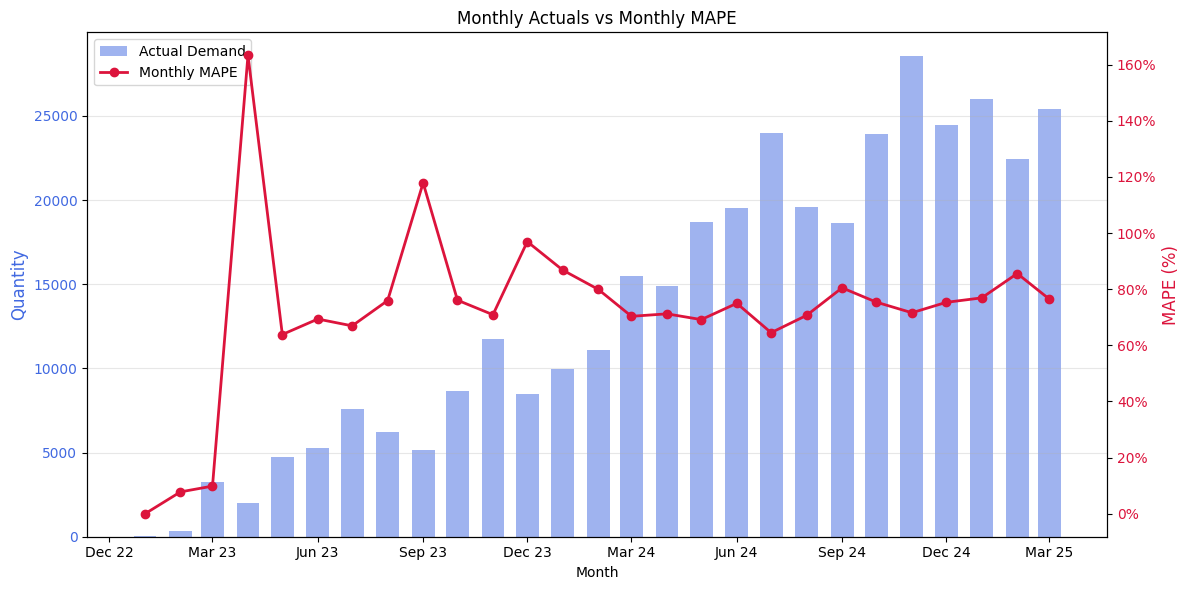

Weighted MAPE across all SKUs and months: 75.31%


In [11]:
monthly_errors['mape'] = (monthly_errors['absolute_error'] / monthly_errors['qty_ordered']) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Plot Actuals (Bars) on Left Axis ---
ax1.bar(monthly_errors['month'], monthly_errors['qty_ordered'], 
        width=20, 
        label='Actual Demand', color='royalblue', alpha=0.5)

ax1.set_xlabel('Month')
ax1.set_ylabel('Quantity', color='royalblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(axis='y', alpha=0.3)

# --- Plot MAPE (Line) on Right Axis ---
ax2 = ax1.twinx()
ax2.plot(monthly_errors['month'], monthly_errors['mape'], 
         label='Monthly MAPE', color='crimson', linewidth=2, marker='o')

ax2.set_ylabel('MAPE (%)', color='crimson', fontsize=12)
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# interval=3 means "show a tick every 3rd month" (Quarterly)
# You can change this to 2 (every other month) or 6 (bi-annually) as needed
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.title('Monthly Actuals vs Monthly MAPE')
plt.xticks(rotation=45)

# Combined Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Compute Weighted MAPE Across All SKUs and Months
def compute_weighted_mape_all(actual, forecast):
# Sum of ALL absolute errors (including where actual is 0)
    total_absolute_error = abs(actual - forecast).sum()
    # Sum of ALL actuals
    total_actual = actual.sum()
    # Avoid division by zero only if the TOTAL sum is 0
    if total_actual == 0:
        return 0.0
        
    return (total_absolute_error / total_actual) * 100

weighted_mape_all = compute_weighted_mape_all(monthly_sales_all['qty_ordered'], monthly_sales_all['forecast'])
print(f"Weighted MAPE across all SKUs and months: {weighted_mape_all:.2f}%")

In [12]:
df_lifecycle

,day,sku,qty_ordered
4822985,2024-02-06,000266EV,1.0
4835630,2024-02-07,000266EV,0.0
4848275,2024-02-08,000266EV,0.0
4860920,2024-02-09,000266EV,0.0
4873565,2024-02-10,000266EV,0.0
...,...,...,...
10066942,2025-03-27,transport35,0.0
10079587,2025-03-28,transport35,0.0
10092232,2025-03-29,transport35,1.0
10104877,2025-03-30,transport35,0.0


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming 'df_lifecycle' is loaded
# df_lifecycle = ...

# ==========================================
# 0. DEFINE BACKTEST SPLIT
# ==========================================
print("--- 0. Splitting Data for Backtesting ---")

max_date = df_lifecycle['day'].max()
cutoff_date = max_date - pd.DateOffset(months=3) # Hold out last 3 months

print(f"Max Date: {max_date.date()}")
print(f"Training Cutoff: {cutoff_date.date()}")

# Split
df_train = df_lifecycle[df_lifecycle['day'] <= cutoff_date].copy()
df_test = df_lifecycle[df_lifecycle['day'] > cutoff_date].copy()

# ==========================================
# 1. FILTERING (Training Data Only)
# ==========================================
print("\n--- 1. Filtering Data (Training) ---")

sku_lifespan = df_train.groupby('sku')['day'].agg(['min', 'max'])
sku_lifespan['lifespan_days'] = (sku_lifespan['max'] - sku_lifespan['min']).dt.days

threshold_days = 360 
mature_skus = sku_lifespan[sku_lifespan['lifespan_days'] >= threshold_days].index
new_skus = sku_lifespan[sku_lifespan['lifespan_days'] < threshold_days].index

df_mature_train = df_train[df_train['sku'].isin(mature_skus)].copy()
df_new_train = df_train[df_train['sku'].isin(new_skus)].copy()

# ==========================================
# 2. TRANSFORMATION & SMOOTHING
# ==========================================
print("\n--- 2. Transforming Profiles ---")

df_mature_train['month'] = df_mature_train['day'].dt.month
df_mature_train['year'] = df_mature_train['day'].dt.year

# Aggregate
monthly_agg = df_mature_train.groupby(['sku', 'year', 'month'])['qty_ordered'].sum().reset_index()
seasonal_profile = monthly_agg.groupby(['sku', 'month'])['qty_ordered'].mean().reset_index()

# Pivot
X_raw = seasonal_profile.pivot(index='sku', columns='month', values='qty_ordered').fillna(0)
for m in range(1, 13):
    if m not in X_raw.columns: X_raw[m] = 0.0
X_raw = X_raw[sorted(X_raw.columns)]

# Normalize
X_norm = X_raw.div(X_raw.sum(axis=1).replace(0, 1), axis=0)

# Smooth (Zig-Zag Fix)
X_smoothed = X_norm.rolling(window=3, axis=1, center=True, min_periods=1).mean().fillna(X_norm)
X_final = X_smoothed.div(X_smoothed.sum(axis=1).replace(0, 1), axis=0)

# ==========================================
# 3. FEATURES
# ==========================================
print("\n--- 3. Extracting Features ---")

def extract_features(norm_df):
    features = pd.DataFrame(index=norm_df.index)
    features['peak_month'] = norm_df.idxmax(axis=1)
    features['seasonality_strength'] = norm_df.max(axis=1) / norm_df.mean(axis=1).replace(0, 1)
    features['skew'] = norm_df.apply(skew, axis=1)
    features['kurtosis'] = norm_df.apply(kurtosis, axis=1)
    return features

X_features = extract_features(X_final)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# ==========================================
# 4. CLUSTERING LOOP (FIND BEST K)
# ==========================================
print("\n--- 4. Finding Best K on Training Data ---")

best_score = -1
best_k = 3
best_model = None

# Search Range: 3 to 10
k_range = range(3, 11)

print(f"{'K':<5} | {'Silhouette Score':<20}")
print("-" * 30)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    
    print(f"{k:<5} | {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = model

print(f"\n> Selected Best K: {best_k} (Score: {best_score:.4f})")

# Apply Best Model
final_labels = best_model.labels_ # Use labels from the best iteration
X_final['Cluster'] = final_labels
cluster_centers = X_final.groupby('Cluster').mean()
sku_cluster_map = pd.Series(final_labels, index=X_final.index, name='Cluster')

# ==========================================
# 5. NEW SKU ASSIGNMENT (Training)
# ==========================================
print("\n--- 5. Assigning New SKUs ---")

df_new_train['month'] = df_new_train['day'].dt.month
new_agg = df_new_train.groupby(['sku', 'month'])['qty_ordered'].sum().reset_index()
new_profiles = new_agg.pivot(index='sku', columns='month', values='qty_ordered').fillna(0)
for m in range(1, 13):
    if m not in new_profiles.columns: new_profiles[m] = 0.0
new_profiles = new_profiles[sorted(new_profiles.columns)]

row_sums_new = new_profiles.sum(axis=1)
new_norm = new_profiles.div(row_sums_new.replace(0, 1), axis=0)

assigned_clusters = []
for sku, row in new_norm.iterrows():
    active_months = row[row > 0].index.tolist()
    if not active_months:
        assigned_clusters.append(-1)
        continue
    # Compare against BEST K centroids
    centroids_partial = cluster_centers[active_months]
    sku_partial = row[active_months]
    distances = np.linalg.norm(centroids_partial - sku_partial, axis=1)
    assigned_clusters.append(np.argmin(distances))

new_sku_map = pd.Series(assigned_clusters, index=new_norm.index, name='Cluster')
full_sku_map = pd.concat([sku_cluster_map, new_sku_map])


--- 0. Splitting Data for Backtesting ---
Max Date: 2025-03-31
Training Cutoff: 2024-12-31

--- 1. Filtering Data (Training) ---

--- 2. Transforming Profiles ---


C:\Users\ruims\AppData\Local\Temp\ipykernel_5236\2279024124.py:65: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  X_smoothed = X_norm.rolling(window=3, axis=1, center=True, min_periods=1).mean().fillna(X_norm)



--- 3. Extracting Features ---

--- 4. Finding Best K on Training Data ---
K     | Silhouette Score    
------------------------------
3     | 0.2616
4     | 0.2534
5     | 0.2576
6     | 0.2638
7     | 0.2654
8     | 0.2590
9     | 0.2527
10    | 0.2392

> Selected Best K: 7 (Score: 0.2654)

--- 5. Assigning New SKUs ---



--- 6. Validating Best K Forecast ---


c:\CDE\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


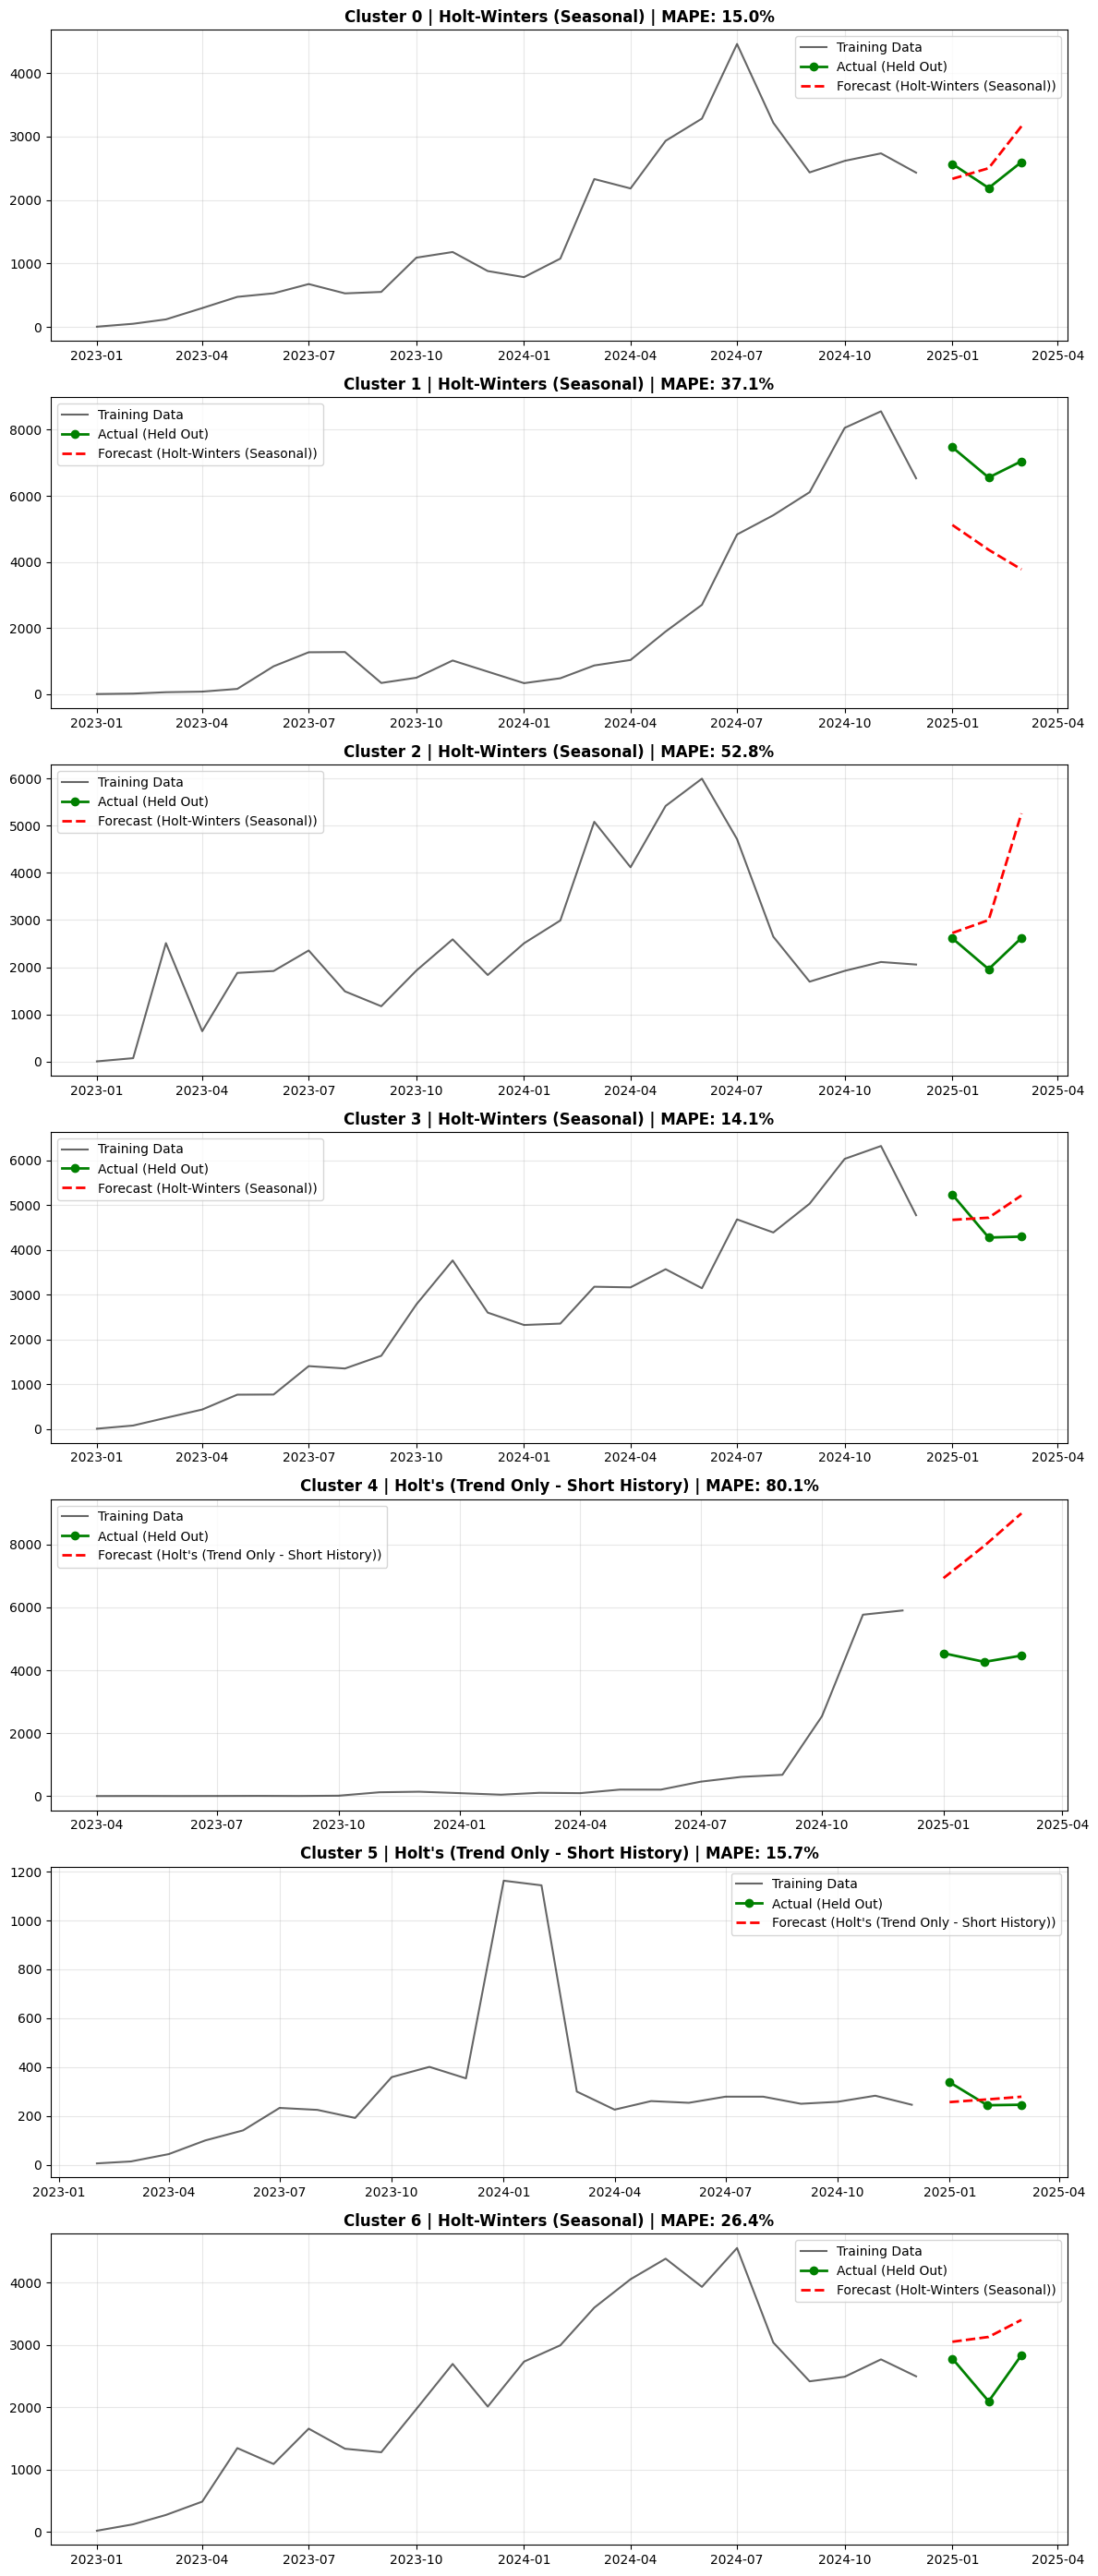

In [41]:
# ==========================================
# 6. FORECAST VALIDATION (Fixed for Short History)
# ==========================================
print("\n--- 6. Validating Best K Forecast ---")

# Merge mappings to full dataset
df_full_scored = df_lifecycle.merge(full_sku_map, left_on='sku', right_index=True, how='inner')

# Aggregate Sales by Cluster & Month
cluster_sales = df_full_scored.groupby(['Cluster', pd.Grouper(key='day', freq='MS')])['qty_ordered'].sum().reset_index()

# Plotting
fig, axes = plt.subplots(best_k, 1, figsize=(12, 4*best_k), sharex=False)
if best_k == 1: axes = [axes]

for cluster_id, ax in zip(range(best_k), axes):
    # Prepare Time Series
    ts_data = cluster_sales[cluster_sales['Cluster'] == cluster_id].set_index('day')['qty_ordered']
    
    # Explicitly set frequency to Month Start to silence warnings
    ts_data = ts_data.asfreq('MS').fillna(0)
    
    # Split Train/Test
    train_ts = ts_data[ts_data.index <= cutoff_date]
    test_ts = ts_data[ts_data.index > cutoff_date]
    
    # --- LOGIC FIX: Handle Short History ---
    if len(train_ts) < 12:
        print(f"Cluster {cluster_id}: Skipped (Not enough history < 12 months)")
        continue
        
    try:
        if len(train_ts) >= 24:
            # Case A: Enough data for Full Seasonality (>= 2 Years)
            model = ExponentialSmoothing(
                train_ts, 
                trend='add', 
                seasonal='add', 
                seasonal_periods=12, 
                initialization_method="estimated"
            ).fit()
            method_label = "Holt-Winters (Seasonal)"
        else:
            # Case B: Limited data (1-2 Years) -> Trend Only, No Seasonality
            # We cannot statistically derive a seasonal curve from 1.5 years of data
            model = ExponentialSmoothing(
                train_ts, 
                trend='add', 
                seasonal=None, 
                initialization_method="estimated"
            ).fit()
            method_label = "Holt's (Trend Only - Short History)"

        # Forecast
        forecast = model.forecast(len(test_ts))
        
        # Calculate Error
        if len(test_ts) > 0:
            mape = mean_absolute_percentage_error(test_ts, forecast)
            error_msg = f"MAPE: {mape:.1%}"
        else:
            error_msg = "No Test Data"
            
        # Plotting
        ax.plot(train_ts.index, train_ts, label='Training Data', color='black', alpha=0.6)
        ax.plot(test_ts.index, test_ts, label='Actual (Held Out)', color='green', marker='o', linewidth=2)
        ax.plot(test_ts.index, forecast, label=f'Forecast ({method_label})', color='red', linestyle='--', linewidth=2)
        
        ax.set_title(f"Cluster {cluster_id} | {method_label} | {error_msg}", fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        print(f"Cluster {cluster_id} Failed: {str(e)}")
        ax.set_title(f"Cluster {cluster_id} - Modeling Failed", fontsize=12, color='red')

plt.tight_layout()
plt.show()